In [101]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn.functional import relu

In [3]:
class_mapping = {
    'person': 0,
    'bird': 1,
    'cat': 2,
    'cow': 3,
    'dog': 4,
    'horse': 5,
    'sheep': 6,
    'aeroplane': 7,
    'bicycle': 8,
    'boat': 9,
    'bus': 10,
    'car': 11,
    'motorbike': 12,
    'train': 13,
    'bottle': 14,
    'chair': 15,
    'diningtable': 16,
    'pottedplant': 17,
    'sofa': 18,
    'tvmonitor': 19
}

In [24]:
def to_target_tensor(num_classes, annotation_dict):
    # Extract image size information
    width = int(annotation_dict['annotation']['size']['width'])
    height = int(annotation_dict['annotation']['size']['height'])

    # Extract bounding box information
    tensor_categories = torch.zeros((20, 224, 224))
    for obj in annotation_dict['annotation']['object']:
        xmin = int((int(obj['bndbox']['xmin']) / width) * 224)
        ymin = int((int(obj['bndbox']['ymin']) / height) * 224)
        xmax = int((int(obj['bndbox']['xmax']) / width) * 224)
        ymax = int((int(obj['bndbox']['ymax']) / height) * 224)
        tensor_categories[class_mapping[obj['name']], xmin:xmax+1, ymin:ymax+1] = 1
        
    return tensor_categories

In [30]:
# Instantiate your weakly supervised dataset
# YourWeaklySupervisedDataset should provide images and their weak annotations
# You need to implement this dataset class
num_classes = 20
# Create a DataLoader for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.Lambda(lambda x: to_target_tensor(num_classes, x))
])
train_dataset = VOCDetection(root='./data', year='2012', image_set='train', download=False, transform=transform, target_transform=target_transform)
print(train_dataset[0][1].shape)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

torch.Size([20, 224, 224])


In [102]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 224x224x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 222x222x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 220x220x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 110x110x64

        # input: 110x110x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 108x108x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 106x106x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 53x53x128

        # input: 53x53x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 51x51x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 49x49x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 24x24x256

        # input: 24x24x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 22x22x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 20x20x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 10x10x512

        # input: 10x10x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 6x6x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

        '''
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        '''

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [103]:
# Set your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = UNet(n_class=20).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [104]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, annotations in train_loader:
        images, annotations = images.to(device), annotations.to(device)

        # Forward pass
        outputs = model(images)
        # Compute your loss based on the weak annotations
        loss = criterion(outputs, annotations)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save or use the trained model for inference
torch.save(model.state_dict(), 'weakly_supervised_segmentation_model.pth')

KeyboardInterrupt: 

(20, 224, 224)


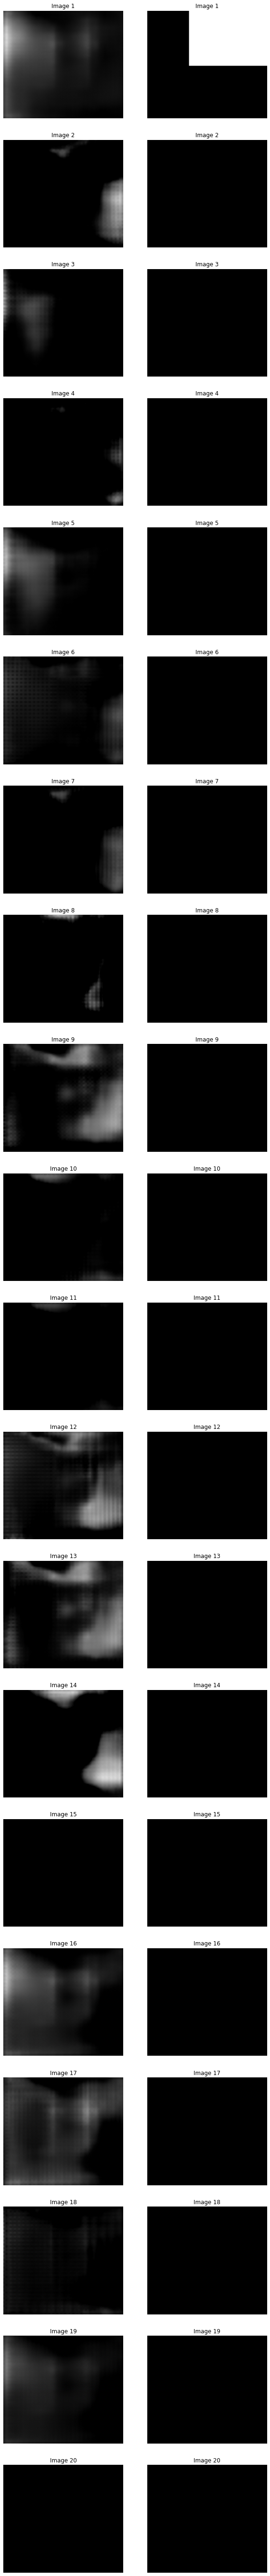

In [91]:
from torchvision.transforms import ToPILImage
from PIL import Image

tensor = model(train_dataset[100][0].unsqueeze(0)).squeeze(0)
normalized_tensor = ((tensor - tensor.min()) / (tensor.max() - tensor.min())).detach().numpy()

print(normalized_tensor.shape)

fig, axes = plt.subplots(20, 2, figsize=(10, 100))

# Plot each normalized grayscale image
for i in range(20):
    axes[i, 0].imshow(normalized_tensor[i], cmap='gray', aspect='auto')
    axes[i, 0].set_title(f'Image {i + 1}')
    axes[i, 0].axis('off')  # Turn off axis labels
    axes[i, 1].imshow(train_dataset[100][1][i], cmap='gray', aspect='auto')
    axes[i, 1].set_title(f'Image {i + 1}')
    axes[i, 1].axis('off')  # Turn off axis labels

plt.show()

In [14]:
# Load the model
model_path = "weakly_supervised_segmentation_model.pth"
checkpoint = torch.load(model_path)
# Load the model's state dictionary
model.load_state_dict(checkpoint)

# Ensure the model is in evaluation mode
model.eval()

# Optionally, you may also load other things such as optimizer state, epoch, etc.
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']

# Now, you can use the loaded model for inference


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  